# Задача

**ML:**

– Научитесь предсказывать совершение целевого действия
(ориентировочное значение ROC-AUC ~ 0.65) — факт совершения
пользователем целевого действия.

– Упакуйте получившуюся модель в сервис, который будет брать на
вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход
0/1 (1 — если пользователь совершит любое целевое действие).




**Целевое действие** — события типа «Оставить заявку» и «Заказать звонок»

(ga_hits.event_action in [
    'sub_car_claim_click', 
    'sub_car_claim_submit_click',
    'sub_open_dialog_click', 
    'sub_custom_question_submit_click',
    'sub_call_number_click', 
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
])

**CR (Conversion Rate)** — показатель конверсии из визита (уникальный
session_id) в любое целевое действие в рамках одного визита (в случае
наличия >1 целевого действия — считать все как одно).

**Органический трафик** — все визиты с:

ga_sessions.utm_medium in (
    'organic',
    'referral',
    '(none)'
)

**Платный трафик** — весь неорганический трафик.

**Информация про марку и модель авто** — содержится в ga_hits.hit_page_path.

**Реклама в социальных сетях** — все визиты с ga_sessions.utm_source in
('QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw',
'gVRrcxiDQubJiljoTbGm').

# Решение

## Импортируем необходимые пакеты

In [1]:
import pandas as pd
import numpy as np
import math
import requests
import json
import datetime
import missingno as msno
import country_converter as coco
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import geopy
from geopy.geocoders import Nominatim

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import pickle

## Считываем данные в датафреймы

In [2]:
df_sessions = pd.read_csv('data/ga_sessions.csv', dtype = {'client_id': 'object'})
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [3]:
df_hits = pd.read_csv('data/ga_hits.csv')
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


## EDA

### Очистка данных

In [702]:
df_sessions.shape

(1860042, 18)

In [703]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [704]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [705]:
# смотрим процент пропущенных значений в каждой колонке
missing_values_sessions = (df_sessions.isna().sum() / len(df_sessions) * 100).sort_values()
missing_values_sessions

session_id                   0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
geo_country                  0.000000
utm_medium                   0.000000
geo_city                     0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
utm_source                   0.005215
utm_campaign                11.806346
utm_adcontent               18.043410
device_brand                19.740307
device_os                   57.533002
utm_keyword                 58.174009
device_model                99.121633
dtype: float64

In [706]:
# 'visit_number' - порядковый номер визита клиента удаляем
df_sessions = df_sessions.drop('visit_number', axis=1)

In [707]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [708]:
df_hits.shape

(15726470, 11)

In [709]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [710]:
# смотрим процент пропущенных значений в каждой колонке
missing_values_hits = (df_hits.isna().sum() / len(df_hits) * 100).sort_values()
missing_values_hits

session_id          0.000000
hit_date            0.000000
hit_number          0.000000
hit_type            0.000000
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
event_label        23.909905
hit_referer        39.899634
hit_time           58.247795
event_value       100.000000
dtype: float64

In [711]:
# целевую переменную переводим в числовой формат 
df_hits.event_value = df_hits.event_action.apply(lambda x: 1 if ((x == 'sub_car_claim_click') |
                                                                           (x == 'sub_car_claim_submit_click') |
                                                                           (x == 'sub_open_dialog_click') |
                                                                           (x == 'sub_custom_question_submit_click') |
                                                                           (x == 'sub_call_number_click') |
                                                                           (x == 'sub_callback_submit_click') |
                                                                           (x == 'sub_submit_success') |
                                                                           (x == 'sub_car_request_submit_click')) else 0)
df_hits.event_value.value_counts().sort_values(ascending=False)

event_value
0    15621562
1      104908
Name: count, dtype: int64

In [712]:
# выборка не сбалансирована

In [719]:
stats = df_hits.groupby(['event_category'], as_index=False).agg(
    {'event_value': 'sum'}).sort_values(ascending=False, by = 'event_value')
stats 

# видим, что целевые действия принадлежат 2ум категориям sub_button_click и sub_submit

,event_category,event_value
46,sub_button_click,86469
48,sub_submit,18439
0,active_invitation,0
38,phone,0
28,greenday_sub_submit,0
29,header,0
30,jivosite,0
31,listing_ads,0
32,main_advantages,0
33,main_banners,0


In [754]:
df_hits[(df_hits['event_category'] == 'sub_button_click') | 
        (df_hits['event_category'] == 'sub_submit')].loc[:, ['event_category', 'event_value']].value_counts()

# в этих категориях не только целевые действия

event_category    event_value
sub_button_click  0              987002
                  1               86469
sub_submit        1               18439
                  0                  56
Name: count, dtype: int64

In [773]:
# вычисляем тетрахорическую корреляцию - используется для расчета корреляции между бинарными категориальными переменными

tetrachoric_correlation = math.cos(np.pi / (1 + math.sqrt(987002 * 18439 / 56 / 86469)))
tetrachoric_correlation

# сильная положительная корреляция, поэтому удалим event_category

0.9987290834400998

In [ ]:
# удалим hit_time, hit_referer и event_label так как там больше 20% пропущенных значений
# а также hit_page_path - url доп информация оттуда не потребуется 
# event_category, event_action - больше не нужны - удалим
# hit_type - одно уникальное значение во всем дф
df_hits = df_hits.drop(['hit_time', 'hit_type', 'hit_referer', 'hit_page_path', 'event_label', 'event_category', 'event_action'], axis=1)

In [474]:
# сгруппируем дф по session_id
stats = df_hits.groupby(['session_id'], as_index=False).agg({'hit_date': 'first',  # берем первую дату
                                                            'hit_number': 'mean',  # средний порядковый номер события в рамках сессии
                                                            'event_value': 'max'})  # 1 если совершено целевое действие
stats.head()

# пока берем средний hit_number так как есть предположение, что 
# чем больше хитов тем больше вероятность того что оставят заявку

,session_id,hit_date,hit_number,event_value
0,1000009318903347362.1632663668.1632663668,2021-09-26,9.200000,0
1,1000010177899156286.1635013443.1635013443,2021-10-23,7.333333,0
2,1000013386240115915.1635402956.1635402956,2021-10-28,9.909091,0
3,1000017303238376207.1623489300.1623489300,2021-06-12,11.000000,0
4,1000020580299877109.1624943350.1624943350,2021-06-29,3.000000,0


In [475]:
df_hits = stats.copy() # копируем сгруппированный дф 

In [476]:
# проверяем, что осталось
missing_values_hits = (df_hits.isna().sum() / len(df_hits) * 100).sort_values()
missing_values_hits

session_id     0.0
hit_date       0.0
hit_number     0.0
event_value    0.0
dtype: float64

In [477]:
df_hits.head()

,session_id,hit_date,hit_number,event_value
0,1000009318903347362.1632663668.1632663668,2021-09-26,9.200000,0
1,1000010177899156286.1635013443.1635013443,2021-10-23,7.333333,0
2,1000013386240115915.1635402956.1635402956,2021-10-28,9.909091,0
3,1000017303238376207.1623489300.1623489300,2021-06-12,11.000000,0
4,1000020580299877109.1624943350.1624943350,2021-06-29,3.000000,0


In [478]:
df_sessions.duplicated().unique() #дублей нет

array([False])

In [479]:
df_hits.duplicated().unique()  #дублей нет

array([False])

In [480]:
#missing_values_sessions = (df_sessions.isna().sum() / len(df_sessions) * 100).sort_values()
#missing_values_sessions

In [481]:
# объединяем датафреймы 
df = pd.merge(df_sessions, df_hits, on='session_id')
df.head()

,session_id,client_id,visit_date,visit_time,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,hit_date,hit_number,event_value
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,2021-11-24,3.50,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,2021-11-14,3.00,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,2021-12-28,12.25,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,2021-05-29,5.00,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,2021-05-29,2.50,0


In [482]:
df.shape # размерность дф, с которым дальше будем работать

(1732266, 20)

In [483]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 20 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   utm_source                object 
 5   utm_medium                object 
 6   utm_campaign              object 
 7   utm_adcontent             object 
 8   utm_keyword               object 
 9   device_category           object 
 10  device_os                 object 
 11  device_brand              object 
 12  device_model              object 
 13  device_screen_resolution  object 
 14  device_browser            object 
 15  geo_country               object 
 16  geo_city                  object 
 17  hit_date                  object 
 18  hit_number                float64
 19  event_value               int64  
dtypes: float64(1), int64(1),

In [484]:
df.duplicated().unique() #дублей нет

array([False])

In [485]:
# сохраняем копию исходного датафрейма
df_clean = df.copy()

In [486]:
# смотрим на процент незаполненных ячеек в колонках
missing_values = (df_clean.isna().sum() / len(df_clean) * 100).sort_values()
missing_values

session_id                   0.000000
hit_date                     0.000000
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
hit_number                   0.000000
device_category              0.000000
utm_medium                   0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
event_value                  0.000000
utm_source                   0.004387
utm_campaign                11.273500
utm_adcontent               17.557177
device_brand                20.042880
device_os                   58.533966
utm_keyword                 58.925823
device_model                99.130503
dtype: float64

In [487]:
# сразу удаляем колонки session_id и client_id, так как значения уникальны, а значит никак не помогут классификации.
df_clean = df_clean.drop(['session_id', 'client_id'], axis = 1)

# удалим колонки 'utm_source', 'utm_campaign', 'utm_adcontent', 'utm_keyword', потому что значения сгенерированы
# а также в некоторых из этих колонок больше 20% пропущенных значений
df_clean = df_clean.drop(['utm_source', 'utm_campaign', 'utm_adcontent', 'utm_keyword'], axis = 1)

# удалим колонку device_model так как в ней более 99% пропущенных значений
df_clean = df_clean.drop('device_model', axis=1)
df_clean.head()

,visit_date,visit_time,utm_medium,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,hit_date,hit_number,event_value
0,2021-11-24,14:36:32,banner,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,2021-11-24,3.50,0
1,2021-11-14,08:21:30,cpm,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,2021-11-14,3.00,0
2,2021-12-28,02:42:06,banner,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,2021-12-28,12.25,0
3,2021-05-29,05:00:00,cpc,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29,5.00,0
4,2021-05-29,05:00:00,cpc,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29,2.50,0


In [488]:
# смотрим на процент незаполненных ячеек в колонках
missing_values = (df_clean.isna().sum() / len(df_clean) * 100).sort_values()
missing_values

visit_date                   0.000000
visit_time                   0.000000
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
hit_date                     0.000000
hit_number                   0.000000
event_value                  0.000000
device_brand                20.042880
device_os                   58.533966
dtype: float64

### 'device_brand', 'device_os'

In [489]:
#device_brand                 20.042880
#device_os                    58.388614

# видим, что в device_brand около 25% пропущенных значений проверим сможем ли заполнить их с помощью device_os

df_clean[df_clean.device_brand.isna() & df_clean.device_os.notna()]

,visit_date,visit_time,utm_medium,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,hit_date,hit_number,event_value
28,2021-12-02,23:53:53,(none),desktop,Windows,NaN,1536x864,Chrome,Russia,Balashikha,2021-12-02,8.714286,0
65,2021-11-15,11:44:26,(none),desktop,Windows,NaN,1920x1080,Chrome,Russia,Saint Petersburg,2021-11-15,19.583333,0
77,2021-11-30,16:18:20,cpm,desktop,Windows,NaN,1680x1050,Chrome,Russia,Moscow,2021-11-30,3.000000,0
86,2021-12-29,21:03:36,(none),desktop,Windows,NaN,1024x820,YaBrowser,Russia,Moscow,2021-12-29,4.000000,0
96,2021-10-29,19:57:48,email,desktop,Windows,NaN,1920x1080,YaBrowser,Russia,Moscow,2021-10-29,3.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732224,2021-11-02,21:34:46,(none),desktop,Windows,NaN,1366x768,Chrome,Russia,Kazan,2021-11-02,3.000000,0
1732233,2021-12-08,19:11:30,referral,desktop,Windows,NaN,1920x1080,Chrome,Russia,Krasnodar,2021-12-08,28.687500,0
1732250,2021-11-13,21:47:58,organic,desktop,Windows,NaN,1366x768,Firefox,Russia,Balashikha,2021-11-13,5.000000,0
1732261,2021-12-22,10:48:25,cpc,desktop,Windows,NaN,1920x1080,Chrome,Russia,Moscow,2021-12-22,3.500000,0


In [490]:
# смотрим на уникальные значения колонки и их количество
df_clean.device_os.value_counts(dropna=False).sort_values(ascending=False)

device_os
NaN              1013964
Android           425520
iOS               182597
Windows            81740
Macintosh          23415
Linux               4616
(not set)            309
Chrome OS             65
BlackBerry            24
Tizen                  7
Firefox OS             3
Nokia                  2
Samsung                2
Windows Phone          2
Name: count, dtype: int64

In [491]:
df_clean.device_brand.value_counts(dropna=False).sort_values(ascending=False)
# больше всего клиентов с девайсами бренда Apple

device_brand
Apple        503533
NaN          347196
Samsung      311641
Xiaomi       269251
Huawei       173828
              ...  
M-HORSE           1
Winnovo           1
Maze              1
Honeywell         1
Maxvi             1
Name: count, Length: 201, dtype: int64

In [492]:
# для владельцев ОС Windows заполним бренд значением Windows
tmp_df = df_clean[(df_clean.device_brand.isna()) & (df_clean.device_os == 'Windows')]
tmp_df.loc[:, 'device_brand'] = 'Windows'
df_clean[(df_clean.device_brand.isna()) & (df_clean.device_os == 'Windows')] = tmp_df

# для владельцев ОС Macintosh заполним бренд значением Apple
tmp_df = df_clean[(df_clean.device_brand.isna()) & (df_clean.device_os == 'Macintosh')]
tmp_df.loc[:, 'device_brand'] = 'Apple'
df_clean[(df_clean.device_brand.isna()) & (df_clean.device_os == 'Macintosh')] = tmp_df

# для владельцев операционной системы Linux установим device_brand = Windows
tmp_df = df_clean[(df_clean.device_brand.isna()) & (df_clean.device_os == 'Linux')]
tmp_df.loc[:, 'device_brand'] = 'Windows'
df_clean[(df_clean.device_brand.isna()) & (df_clean.device_os == 'Linux')] = tmp_df

# все остальные пропуски заполним значением other
df_clean.device_brand = df_clean.device_brand.fillna('other')
df_clean.device_brand = df_clean.device_brand.replace('(not set)', 'other')

# проверим, что нулевых значений не осталось
df_clean.device_brand.isna().sum()

0

In [493]:
# удаляем колонку device_os так как там больше 58% пропущенных значений
df_clean = df_clean.drop('device_os', axis = 1)

In [494]:
# проверим процент пропущенных значений в оставшихся колонках
missing_values = (df_clean.isna().sum() / len(df_clean) * 100).sort_values()
missing_values

visit_date                  0.0
visit_time                  0.0
utm_medium                  0.0
device_category             0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
hit_date                    0.0
hit_number                  0.0
event_value                 0.0
dtype: float64

### 'visit_date', 'hit_date'+

In [495]:
df_clean[['visit_date', 'hit_date']]

,visit_date,hit_date
0,2021-11-24,2021-11-24
1,2021-11-14,2021-11-14
2,2021-12-28,2021-12-28
3,2021-05-29,2021-05-29
4,2021-05-29,2021-05-29
...,...,...
1732261,2021-12-22,2021-12-22
1732262,2021-05-26,2021-05-26
1732263,2021-11-15,2021-11-15
1732264,2021-11-29,2021-11-29


In [496]:
# убедимся, что колонки одинаковы
df_clean[df_clean.visit_date != df_clean.hit_date] 

,visit_date,visit_time,utm_medium,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,hit_date,hit_number,event_value


In [497]:
# колонки равны, значит можно удалить дублирующуюся и переименовать колонку в date
df_clean['date'] = df_clean.visit_date
df_clean = df_clean.drop(['visit_date', 'hit_date'], axis=1)
df_clean.head()

,visit_time,utm_medium,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,hit_number,event_value,date
0,14:36:32,banner,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,3.50,0,2021-11-24
1,08:21:30,cpm,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,3.00,0,2021-11-14
2,02:42:06,banner,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,12.25,0,2021-12-28
3,05:00:00,cpc,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,5.00,0,2021-05-29
4,05:00:00,cpc,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,2.50,0,2021-05-29


### device_screen_resolution

In [498]:
df_clean.device_screen_resolution

0            360x720
1            385x854
2            360x720
3            393x786
4            393x786
             ...    
1732261    1920x1080
1732262      390x844
1732263      375x667
1732264      393x851
1732265     1366x768
Name: device_screen_resolution, Length: 1732266, dtype: object

In [499]:
# заменим device_screen_resolution на площадь экрана
df_w = df_clean.device_screen_resolution.apply(lambda x: x.split('x')[0])
df_w = df_w.astype('int')
df_w

0           360
1           385
2           360
3           393
4           393
           ... 
1732261    1920
1732262     390
1732263     375
1732264     393
1732265    1366
Name: device_screen_resolution, Length: 1732266, dtype: int64

In [500]:
df_h = df_clean.device_screen_resolution.apply(lambda x: x.split('x')[1])
df_h = df_h.astype('int')
df_h

0           720
1           854
2           720
3           786
4           786
           ... 
1732261    1080
1732262     844
1732263     667
1732264     851
1732265     768
Name: device_screen_resolution, Length: 1732266, dtype: int64

In [501]:
df_clean['device_screen'] = df_w * df_h
df_clean['device_screen']

0           259200
1           328790
2           259200
3           308898
4           308898
            ...   
1732261    2073600
1732262     329160
1732263     250125
1732264     334443
1732265    1049088
Name: device_screen, Length: 1732266, dtype: int64

In [502]:
# удаляем колонку device_screen_resolution - больше не нужна
df_clean = df_clean.drop(['device_screen_resolution'], axis=1)
df_clean.head()

,visit_time,utm_medium,device_category,device_brand,device_browser,geo_country,geo_city,hit_number,event_value,date,device_screen
0,14:36:32,banner,mobile,Huawei,Chrome,Russia,Zlatoust,3.50,0,2021-11-24,259200
1,08:21:30,cpm,mobile,Samsung,Samsung Internet,Russia,Moscow,3.00,0,2021-11-14,328790
2,02:42:06,banner,mobile,Huawei,Chrome,Russia,Krasnoyarsk,12.25,0,2021-12-28,259200
3,05:00:00,cpc,mobile,Xiaomi,Chrome,Russia,Moscow,5.00,0,2021-05-29,308898
4,05:00:00,cpc,mobile,Xiaomi,Chrome,Russia,Moscow,2.50,0,2021-05-29,308898


### utm_medium

In [503]:
df_clean.utm_medium.value_counts().sort_values(ascending=False)

utm_medium
banner               525206
cpc                  399395
(none)               277060
cpm                  229791
referral             136851
organic               55009
email                 28287
push                  27710
stories               10472
cpv                    7815
blogger_channel        7731
smartbanner            6501
blogger_stories        4226
tg                     3920
cpa                    3266
post                   2227
outlook                1269
app                    1211
smm                    1194
clicks                  908
blogger_header          760
(not set)               405
info_text               335
sms                     194
landing                 127
partner                  95
link                     52
cbaafe                   43
CPM                      36
yandex_cpc               31
vk_smm                   25
static                   17
google_cpc               15
article                  15
web_polka                11
fb_smm   

In [504]:
# немного преобразуем utm_medium чтобы уменьшить количество уникальных значений
df_clean.utm_medium = df_clean.utm_medium.apply(lambda x: x.lower())
df_clean.utm_medium.value_counts().sort_values(ascending=False)

utm_medium
banner               525206
cpc                  399395
(none)               277060
cpm                  229827
referral             136851
organic               55009
email                 28287
push                  27710
stories               10472
cpv                    7815
blogger_channel        7731
smartbanner            6501
blogger_stories        4226
tg                     3920
cpa                    3266
post                   2227
outlook                1269
app                    1211
smm                    1194
clicks                  908
blogger_header          760
(not set)               405
info_text               335
sms                     194
landing                 127
partner                  95
link                     52
cbaafe                   43
yandex_cpc               31
vk_smm                   25
static                   17
google_cpc               15
article                  15
web_polka                11
fb_smm                    8
medium   

In [505]:
df_clean[['utm_medium', 'event_value']]

,utm_medium,event_value
0,banner,0
1,cpm,0
2,banner,0
3,cpc,0
4,cpc,0
...,...,...
1732261,cpc,0
1732262,(none),0
1732263,(none),0
1732264,banner,0


In [506]:
# сгруппируем дф по utm_medium и посмотрим какой тип привлечения дает больше целевых действий
stats = df_clean.groupby(['utm_medium'], as_index=False).agg({'event_value': 'sum'}).sort_values(ascending=False, by='event_value')
stats = stats.rename(columns = {'event_value': 'sum'})
stats

# лучше всего работает тип привлечения banner, (none) - органический трафик по условию задачи

,utm_medium,sum
4,banner,15107
0,(none),10531
12,cpc,9529
39,referral,8181
13,cpm,2522
29,organic,2100
35,push,840
16,email,401
42,smartbanner,179
5,blogger_channel,162


In [507]:
# выберем только те типы привлечения, из которых не было совершено ни одного целевого действия
utm_medium_list = stats[stats['sum'] == 0].loc[:, 'utm_medium'].tolist()
utm_medium_list

['ok_smm',
 'web_polka',
 'vk_smm',
 'users_msk',
 'article',
 'tablet',
 'catalogue',
 'cbaafe',
 'google_cpc',
 'landing_interests',
 'sbol_catalog',
 'sber_app',
 'last',
 'reach',
 'qrcodevideo',
 'qr',
 'linktest',
 'promo_sbol',
 'promo_sber',
 'main_polka',
 'nkp']

In [508]:
# заменим их на значение other
for el in utm_medium_list:
    df_clean.utm_medium = df_clean.utm_medium.replace(el, 'other')

In [509]:
# заменим не заданные значения на other
df_clean.utm_medium = df_clean.utm_medium.replace('(not set)', 'other')

# заменим (none) на organic, так как это тоже органический трафик
df_clean.utm_medium = df_clean.utm_medium.replace('(none)', 'organic')
df_clean.utm_medium.value_counts().sort_values(ascending=False)

utm_medium
banner             525206
cpc                399395
organic            332069
cpm                229827
referral           136851
email               28287
push                27710
stories             10472
cpv                  7815
blogger_channel      7731
smartbanner          6501
blogger_stories      4226
tg                   3920
cpa                  3266
post                 2227
outlook              1269
app                  1211
smm                  1194
clicks                908
blogger_header        760
other                 548
info_text             335
sms                   194
landing               127
partner                95
link                   52
yandex_cpc             31
static                 17
fb_smm                  8
medium                  8
social                  5
dom_click               1
Name: count, dtype: int64

In [510]:
df_clean.utm_medium.nunique() # сократили количество уникальных значений utm_medium

32

### device_category

In [511]:
df_clean.device_category.value_counts(dropna=False).sort_values(ascending=False)
# тут все чисто - больше всего пользователей заходят с мобильных устройств

device_category
mobile     1368679
desktop     346891
tablet       16696
Name: count, dtype: int64

### device_brand

In [512]:
df_clean.device_brand.value_counts().sort_values(ascending=False)

device_brand
Apple        526948
Samsung      311641
Xiaomi       269251
other        253817
Huawei       173828
              ...  
M-HORSE           1
Winnovo           1
Maze              1
Honeywell         1
Maxvi             1
Name: count, Length: 201, dtype: int64

In [513]:
df_clean.device_brand.nunique() # 201 бренд многовато, сократим

201

In [514]:
df_clean.device_brand = df_clean.device_brand.apply(lambda x: x.lower())

In [515]:
df_clean.device_brand.value_counts().sort_values(ascending=False)

device_brand
apple        526948
samsung      311641
xiaomi       269251
other        253817
huawei       173828
              ...  
m-horse           1
winnovo           1
maze              1
honeywell         1
maxvi             1
Name: count, Length: 201, dtype: int64

In [516]:
df_clean[df_clean.device_brand == '(not set)'] 

,visit_time,utm_medium,device_category,device_brand,device_browser,geo_country,geo_city,hit_number,event_value,date,device_screen


In [517]:
# сгруппируем дф по device_brand
stats = df_clean.groupby(['device_brand'],as_index=False).agg({'device_category': 'count'}).sort_values(ascending=False, by = 'device_category')
stats = stats.rename(columns = {'device_category': 'count'})
stats

,device_brand,count
8,apple,526948
148,samsung,311641
196,xiaomi,269251
133,other,253817
75,huawei,173828
...,...,...
105,m-horse,1
169,tonbux,1
25,centric,1
132,orbic,1


In [518]:
# выделим бренды, которых меньше 1000
device_brands_list = stats[stats['count'] < 1000].loc[:, 'device_brand'].unique().tolist()
device_brands_list

['alcatel',
 'doogee',
 'oukitel',
 'htc',
 'umidigi',
 'ulefone',
 'infinix',
 'vsmart',
 'leeco',
 'blackberry',
 'cubot',
 'philips',
 'mozilla',
 'poco',
 'sharp',
 'vertex',
 'tp-link',
 'dexp',
 'prestigio',
 'leagoo',
 'micromax',
 'wileyfox',
 'neffos',
 'inoi',
 'hisense',
 'tcl',
 'homtom',
 'cat',
 'karbonn',
 'letv',
 'highscreen',
 'coolpad',
 'agm',
 'acer',
 'haier',
 'black fox',
 'teclast',
 'mito',
 'chuwi',
 'fly',
 'inew',
 'vernee',
 'kyocera',
 'nomu',
 'nuu',
 'wiko',
 'elephone',
 'kingplay',
 'gionee',
 'sonyericsson',
 'digma',
 'smartisan',
 'noa',
 'alldocube',
 'general mobile',
 'blu',
 'tele2',
 'amazon',
 'symphony',
 'kata',
 'zoji',
 'celkon',
 'lava',
 'pantech',
 'qmobile',
 'irbis',
 'gome',
 'yota devices',
 'komu',
 'e&l',
 'condor',
 'ark',
 'razer',
 'china phone',
 'poptel',
 'oysters',
 'billion',
 'flexymove',
 'wigor',
 'mtc',
 'ananda',
 'artel',
 'thl',
 'inui',
 'explay',
 'unihertz',
 'iris',
 'bluboo',
 'a1',
 'mediatek',
 'infocus',
 '

In [519]:
# заменим их на other
df_clean.device_brand = df_clean.device_brand.replace(device_brands_list, 'other')

In [520]:
df_clean.device_brand.value_counts()

device_brand
apple        526948
samsung      311641
xiaomi       269251
other        263771
huawei       173828
windows       86356
realme        17926
oppo          12775
vivo          11026
oneplus        9322
asus           7487
nokia          6864
sony           6106
zte            5987
google         4472
meizu          3529
lenovo         2942
blackview      2592
tecno          2501
lg             2256
motorola       2189
bq             1466
itel           1031
Name: count, dtype: int64

In [521]:
df_clean.device_brand.nunique() # сократили количество брендов до 23

23

### device_browser

In [522]:
df_clean.device_browser.value_counts().sort_values(ascending=False)

device_browser
Chrome                              951573
Safari                              436705
YaBrowser                           123765
Safari (in-app)                      65952
Android Webview                      51919
Samsung Internet                     44273
Opera                                25094
Firefox                              15738
Edge                                 15196
UC Browser                             815
Mozilla Compatible Agent               336
Android Runtime                        241
[FBAN                                  115
MRCHROME                                72
Instagram 208.0.0.32.135 Android        72
Instagram 209.0.0.21.119 Android        49
Android Browser                         47
Puffin                                  43
Maxthon                                 30
Internet Explorer                       24
Opera Mini                              23
Android                                 19
Instagram 202.0.0.23.119               

In [523]:
df_clean.device_browser.nunique()

55

In [524]:
# заменим не заданные значения на other
df_clean.device_browser = df_clean.device_browser.replace('(not set)', 'other')

In [525]:
# возьмем только первое слово до пробела - уменьшим количество уникальных значений
df_clean.device_browser = df_clean.device_browser.apply(lambda x: x.lower().split(' ')[0])
df_clean.device_browser.value_counts().sort_values(ascending=False)

device_browser
chrome                      951573
safari                      502657
yabrowser                   123765
android                      52226
samsung                      44273
opera                        25117
firefox                      15738
edge                         15196
uc                             815
mozilla                        352
instagram                      218
[fban                          115
mrchrome                        72
puffin                          43
maxthon                         30
internet                        24
other                           11
com.vk.vkclient                  8
coc                              6
helloworld                       6
amazon                           6
seamonkey                        3
myapp                            2
netfront                         2
iron                             2
mt6735_td                        1
nokiax2-02                       1
nokia501                         1
com.z

In [526]:
df_clean.device_browser.nunique()

31

### geo_country, geo_city

In [528]:
df_saved = df_clean.copy()

In [530]:
df_clean.shape

(1732266, 11)

In [531]:
df_clean.geo_country

0          Russia
1          Russia
2          Russia
3          Russia
4          Russia
            ...  
1732261    Russia
1732262    Russia
1732263    Russia
1732264    Russia
1732265    Russia
Name: geo_country, Length: 1732266, dtype: object

In [532]:
# больше всего целевых действий совершено из России
df_clean[df_clean.event_value == 1].loc[:, 'geo_country'].value_counts().sort_values(ascending=False)

geo_country
Russia           49156
Ukraine            199
Germany             78
United States       64
Belarus             59
                 ...  
Hong Kong            1
Nigeria              1
Ireland              1
India                1
Iran                 1
Name: count, Length: 75, dtype: int64

In [533]:
# больше всего целевых действий совершено из Москвы и Питера
df_clean[df_clean.event_value == 1].loc[:, 'geo_city'].value_counts().sort_values(ascending=False)

geo_city
Moscow              23629
Saint Petersburg     7113
(not set)            1588
Kazan                1139
Krasnodar            1081
                    ...  
Belaya Kalitva          1
Syzran                  1
Agadir                  1
Bonn                    1
Sharm El-Sheikh         1
Name: count, Length: 631, dtype: int64

In [534]:
stats = df_clean.groupby(['geo_country'], as_index=False).agg({'event_value': 'sum'}).sort_values(ascending=False, by = 'event_value' )
stats = stats.rename(columns = {'event_value': 'sum'})
stats

# целевые действия не только из России

,geo_country,sum
117,Russia,49156
148,Ukraine,199
50,Germany,78
151,United States,64
16,Belarus,59
...,...,...
80,Luxembourg,0
78,Libya,0
77,Lebanon,0
22,Burundi,0


In [535]:
df_clean[(df_clean.geo_country == '(not set)')].shape

(1071, 11)

In [536]:
df_clean[(df_clean.geo_city == '(not set)')].shape

(73297, 11)

In [537]:
# удалим строки, где не указана страна
index_list = df_clean[(df_clean.geo_country == '(not set)') & (df_clean.geo_city == '(not set)')].index.tolist()
df_clean = df_clean.drop(index_list, axis=0)
df_clean.shape

(1731195, 11)

In [538]:
# заменим (not set) на ''
df_clean.geo_city = df_clean.geo_city.replace('(not set)', '')
df_clean.geo_city = df_clean.geo_city.replace("'", "")

In [539]:
# создадим новую фичу полный адрес страна+город
df_clean['full_address'] = df_clean.geo_country.str.cat(others=df_clean.geo_city, sep=', ', na_rep='')

In [540]:
df_clean['full_address']

0             Russia, Zlatoust
1               Russia, Moscow
2          Russia, Krasnoyarsk
3               Russia, Moscow
4               Russia, Moscow
                  ...         
1732261         Russia, Moscow
1732262      Russia, Stavropol
1732263         Russia, Moscow
1732264    Russia, Chelyabinsk
1732265         Russia, Moscow
Name: full_address, Length: 1731195, dtype: object

In [541]:
tmp_df = df_clean.loc[:, ['full_address']]
tmp_df.head()

,full_address
0,"Russia, Zlatoust"
1,"Russia, Moscow"
2,"Russia, Krasnoyarsk"
3,"Russia, Moscow"
4,"Russia, Moscow"


In [542]:
tmp_df.shape

(1731195, 1)

In [543]:
# возьмем только уникальные строки
tmp_df = tmp_df.drop_duplicates()
tmp_df.head()

,full_address
0,"Russia, Zlatoust"
1,"Russia, Moscow"
2,"Russia, Krasnoyarsk"
5,"Russia, Saint Petersburg"
13,"Russia, Sochi"


In [544]:
tmp_df.shape

(2531, 1)

In [545]:
# для ускорения теста берем образец поменьше
# tmp_df = tmp_df.sample(frac = 0.01)
# tmp_df.shape

In [546]:
# функция, которая запрашивает по стране+городу широту и долготу с openstreetmap
def get_lat_lon(address):
        url = f'https://nominatim.openstreetmap.org/search?q={address}&format=json&accept-language=en&NOMINATIM_REQUEST_TIMEOUT=None'
        headers = {'user-agent': 'my-app/0.0.1'}

        response = requests.get(url=url, headers=headers)
        response.raise_for_status()

        if response.status_code != 204:
            result_json = response.json()
            if result_json:   # если точка нашлась, то вернуть широту и долготу
                return result_json[0]['lat'], result_json[0]['lon']
            else:
                return 0, 0   # иначе вернуть 0, 0

In [547]:
# функция, которая возвращает словарь {страна+город: широта-долгота}
def lat_lon_dict(data):
    country_list = data.full_address.tolist()
    lat_lon_list = data.lat_lon.tolist()

    ll_dict = {}
    for k, v in zip(country_list, lat_lon_list):
        ll_dict[k] = v

    return ll_dict

In [548]:
tmp_df['lat_lon'] = tmp_df['full_address'].apply(lambda x: get_lat_lon(x))
tmp_df.loc[:, ['full_address', 'lat_lon']]

,full_address,lat_lon
0,"Russia, Zlatoust","(55.1674213, 59.6792625)"
1,"Russia, Moscow","(55.7505412, 37.6174782)"
2,"Russia, Krasnoyarsk","(56.0090968, 92.8725147)"
5,"Russia, Saint Petersburg","(59.9606739, 30.1586551)"
13,"Russia, Sochi","(43.5854823, 39.723109)"
...,...,...
1728122,"United States, Frederick","(39.2127031, -78.279166)"
1729536,"Netherlands, Nijmegen","(51.8474946, 5.8637771)"
1729668,"Germany, Rosenheim","(47.8539273, 12.127262)"
1730596,"United States, Palatka","(29.6487882, -81.6372111)"


In [552]:
df_clean.loc[:, 'lat_lon'] = df_clean.loc[:, 'full_address']

# с помощью словаря заполняем значения в рабочем дф
df_clean['lat_lon'] = df_clean['lat_lon'].apply(lambda x: lat_lon_dict(tmp_df).get(x))

# создаем отдельные колонки под ширину и долготу
df_clean.loc[:, 'lat'] = df_clean.lat_lon.apply(lambda x: round(float(x[0]), 4))
df_clean.loc[:, 'lon'] = df_clean.lat_lon.apply(lambda x: round(float(x[1]), 4))

In [553]:
# удаляем колонки так как они больше не нужны
df_clean = df_clean.drop(['geo_country', 'geo_city', 'full_address', 'lat_lon'], axis=1)

In [554]:
df_clean.shape

(1731195, 11)

### Проверка типов данных и feature engineering

In [555]:
df_types = df_clean.copy()

In [556]:
df_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1731195 entries, 0 to 1732265
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   visit_time       object 
 1   utm_medium       object 
 2   device_category  object 
 3   device_brand     object 
 4   device_browser   object 
 5   hit_number       float64
 6   event_value      int64  
 7   date             object 
 8   device_screen    int64  
 9   lat              float64
 10  lon              float64
dtypes: float64(3), int64(2), object(6)
memory usage: 158.5+ MB


In [557]:
df_types.event_value = df_types.event_value.astype('int')

In [558]:
# дату приводим к соответствующему типу / создаем отдельные фичи под день/месяц/год
df_types.date = pd.to_datetime(df_types.date, utc=True)

In [559]:
df_types['dayofweek'] = df_types.date.dt.weekday 

In [560]:
df_types['month'] = df_types.date.dt.month 

In [561]:
df_types['year'] = df_types.date.dt.year

In [562]:
df_types['year'].value_counts()

year
2021    1731195
Name: count, dtype: int64

In [563]:
# удалим год, так как одно уникальное значение
df_types = df_types.drop('year', axis=1)

In [564]:
df_types = df_types.drop(['visit_time', 'date'], axis=1)
df_types.head()

,utm_medium,device_category,device_brand,device_browser,hit_number,event_value,device_screen,lat,lon,dayofweek,month
0,banner,mobile,huawei,chrome,3.50,0,259200,55.1674,59.6793,2,11
1,cpm,mobile,samsung,samsung,3.00,0,328790,55.7505,37.6175,6,11
2,banner,mobile,huawei,chrome,12.25,0,259200,56.0091,92.8725,1,12
3,cpc,mobile,xiaomi,chrome,5.00,0,308898,55.7505,37.6175,5,5
4,cpc,mobile,xiaomi,chrome,2.50,0,308898,55.7505,37.6175,5,5


In [565]:
df_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1731195 entries, 0 to 1732265
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   utm_medium       object 
 1   device_category  object 
 2   device_brand     object 
 3   device_browser   object 
 4   hit_number       float64
 5   event_value      int64  
 6   device_screen    int64  
 7   lat              float64
 8   lon              float64
 9   dayofweek        int32  
 10  month            int32  
dtypes: float64(3), int32(2), int64(2), object(4)
memory usage: 145.3+ MB


### Проверка на выбросы

In [639]:
df_check = df_types.copy()

In [640]:
df_check.columns

Index(['utm_medium', 'device_category', 'device_brand', 'device_browser',
       'hit_number', 'event_value', 'device_screen', 'lat', 'lon', 'dayofweek',
       'month'],
      dtype='object')

In [641]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [642]:
df_check.month.value_counts().sort_values(ascending=False)
# 12 месяцев

month
12    366096
11    263723
10    263355
9     243670
7     174558
6     160447
8     154861
5     104485
Name: count, dtype: int64

In [643]:
df_check.dayofweek.value_counts().sort_values(ascending=False)
# 7 дней недели от 0 до 6

dayofweek
1    286801
0    281564
3    252084
4    248410
2    240791
5    211065
6    210480
Name: count, dtype: int64

In [644]:
df_check.device_screen.value_counts().sort_values(ascending=False)

device_screen
370944     155046
2073600    119142
334443     114483
304500     106884
280800      89943
            ...  
372816          1
426120          1
3332025         1
2271360         1
521072          1
Name: count, Length: 4503, dtype: int64

Text(0.5, 1.0, 'График распределения device_screen')

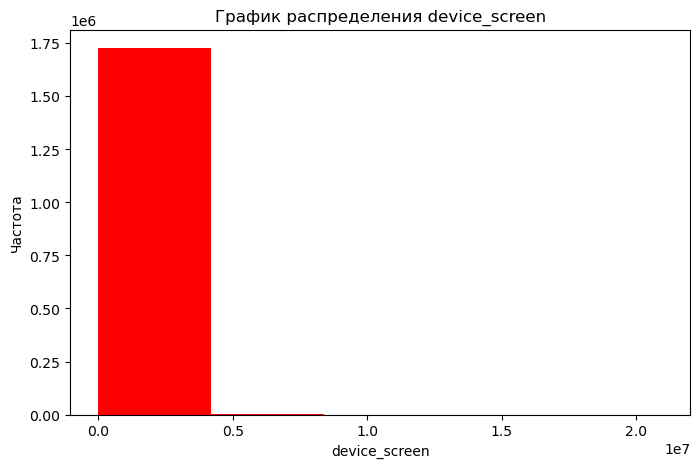

In [645]:
plt.figure(figsize = (8, 5))
plt.hist(df_check.device_screen, color = 'red', bins = 5);
plt.xlabel('device_screen')
plt.ylabel('Частота')
plt.title('График распределения device_screen')

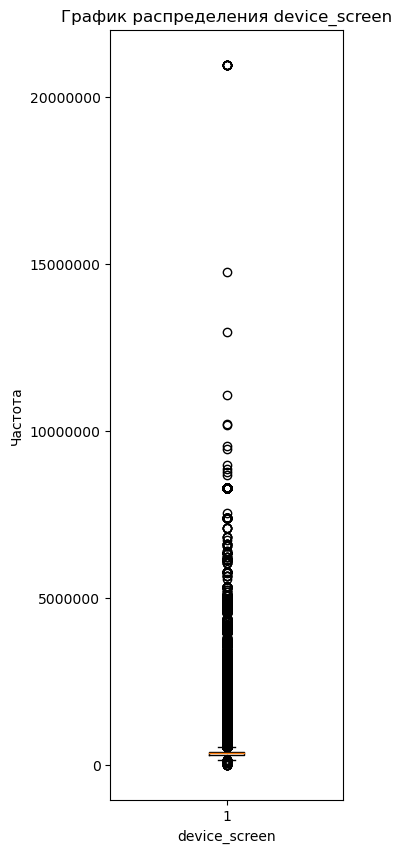

In [646]:
# ящик с усами, выбросы видны вне "ящика"
fig, ax = plt.subplots(figsize = (3, 10))
ax.boxplot(df_check.device_screen)
ax.set_xlabel('device_screen')
ax.set_ylabel('Частота')
ax.set_title('График распределения device_screen')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [647]:
boundaries = calculate_outliers(df_check.device_screen)

# присвоим выбросам значения границ
df_check.loc[df_check.device_screen > boundaries[1], 'device_screen'] = boundaries[1]
df_check.loc[df_check.device_screen < boundaries[0], 'device_screen'] = boundaries[0]  

In [648]:
df_check.device_screen.value_counts().sort_values(ascending=False)

device_screen
521250    361128
370944    155046
334443    114483
304500    106884
280800     89943
           ...  
337536         1
293508         1
334456         1
485541         1
521072         1
Name: count, Length: 2621, dtype: int64

Text(0.5, 1.0, 'График распределения hit_number')

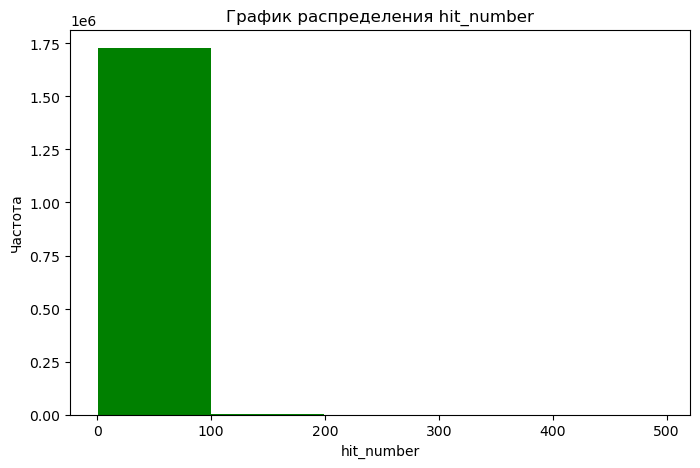

In [649]:
plt.figure(figsize = (8, 5))
plt.hist(df_check.hit_number, color = 'green', bins = 5);
plt.xlabel('hit_number')
plt.ylabel('Частота')
plt.title('График распределения hit_number')

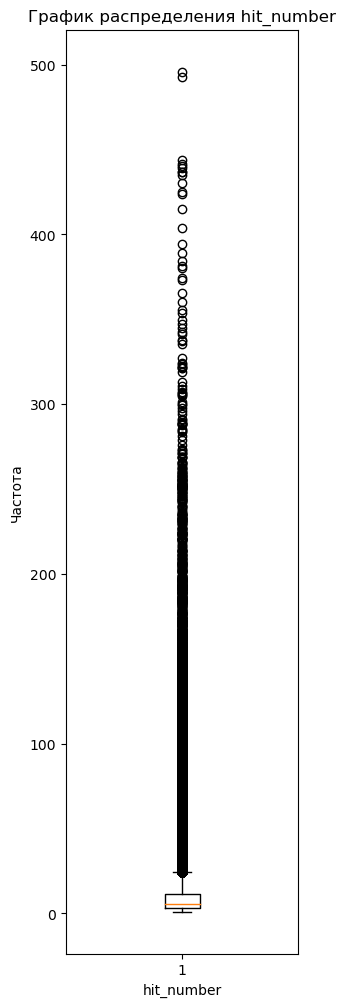

In [650]:
fig, ax = plt.subplots(figsize = (3, 12))
ax.boxplot(df_check.hit_number)
ax.set_xlabel('hit_number')
ax.set_ylabel('Частота')
ax.set_title('График распределения hit_number')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [651]:
boundaries = calculate_outliers(df_check.hit_number)

# присвоим выбросам значение моды
df_check.loc[df_check.hit_number > boundaries[1], 'hit_number'] = df_check.hit_number.mode()[0]

In [665]:
df = df_check.copy()

### Data Visualization

In [666]:
df.head()

,utm_medium,device_category,device_brand,device_browser,hit_number,event_value,device_screen,lat,lon,dayofweek,month
0,banner,mobile,huawei,chrome,3.50,0,259200,55.1674,59.6793,2,11
1,cpm,mobile,samsung,samsung,3.00,0,328790,55.7505,37.6175,6,11
2,banner,mobile,huawei,chrome,12.25,0,259200,56.0091,92.8725,1,12
3,cpc,mobile,xiaomi,chrome,5.00,0,308898,55.7505,37.6175,5,5
4,cpc,mobile,xiaomi,chrome,2.50,0,308898,55.7505,37.6175,5,5


In [667]:
numeric_df = df[['hit_number', 'device_screen', 'dayofweek', 'month', 'event_value', 'lat', 'lon']]

In [668]:
numeric_df.corr() # слабая линейная корреляция между числовыми признаками

,hit_number,device_screen,dayofweek,month,event_value,lat,lon
hit_number,1.000000,0.062453,-0.024197,-0.003795,0.095539,-0.019046,0.018025
device_screen,0.062453,1.000000,-0.068024,-0.128998,0.015387,0.038199,-0.049038
dayofweek,-0.024197,-0.068024,1.000000,0.092178,-0.014479,0.007163,0.021598
month,-0.003795,-0.128998,0.092178,1.000000,-0.051382,-0.057295,0.050540
event_value,0.095539,0.015387,-0.014479,-0.051382,1.000000,-0.007340,-0.004830
lat,-0.019046,0.038199,0.007163,-0.057295,-0.007340,1.000000,0.141372
lon,0.018025,-0.049038,0.021598,0.050540,-0.004830,0.141372,1.000000


In [669]:
df.head()

,utm_medium,device_category,device_brand,device_browser,hit_number,event_value,device_screen,lat,lon,dayofweek,month
0,banner,mobile,huawei,chrome,3.50,0,259200,55.1674,59.6793,2,11
1,cpm,mobile,samsung,samsung,3.00,0,328790,55.7505,37.6175,6,11
2,banner,mobile,huawei,chrome,12.25,0,259200,56.0091,92.8725,1,12
3,cpc,mobile,xiaomi,chrome,5.00,0,308898,55.7505,37.6175,5,5
4,cpc,mobile,xiaomi,chrome,2.50,0,308898,55.7505,37.6175,5,5


In [670]:
stats = df.groupby(['utm_medium'], as_index=False).agg({'event_value': 'sum'}).sort_values(ascending=False, by='event_value')
stats = stats.rename(columns = {'event_value': 'sum'})
stats

,utm_medium,sum
1,banner,15102
17,organic,12617
7,cpc,9527
23,referral,8175
8,cpm,2522
22,push,839
11,email,400
24,smartbanner,179
2,blogger_channel,162
6,cpa,131


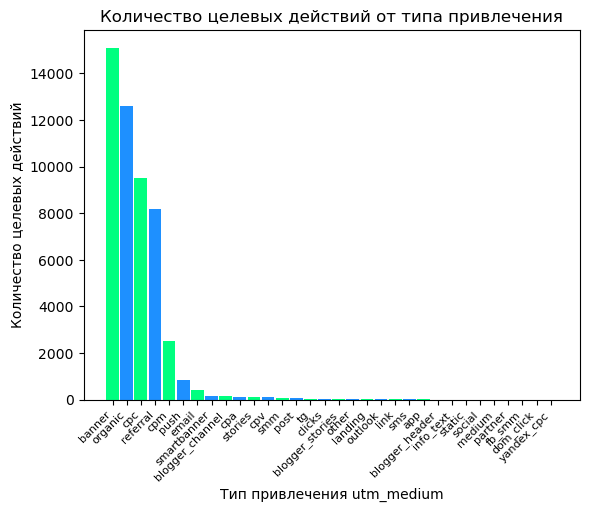

In [671]:
plt.bar(stats['utm_medium'], stats['sum'], width = 0.9, color = ['springgreen', 'dodgerblue'])
plt.xticks(rotation=45, horizontalalignment='right', fontsize=8)
plt.xlabel('Тип привлечения utm_medium')
plt.ylabel('Количество целевых действий')
plt.title('Количество целевых действий от типа привлечения')
plt.show()

In [672]:
stats = df.groupby(['hit_number'], as_index=False).agg({'event_value': 'sum'}).sort_values(ascending=False, by='event_value')
stats = stats.rename(columns = {'event_value': 'sum'})
stats

,hit_number,sum
7,3.000000,15659
12,3.500000,1182
18,4.000000,1021
68,6.000000,558
27,4.500000,517
...,...,...
3293,21.914286,0
1785,17.758621,0
3289,21.906250,0
3286,21.900000,0


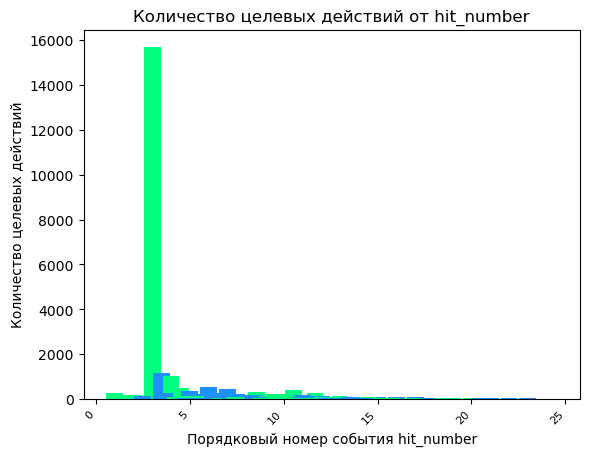

In [673]:
plt.bar(stats['hit_number'], stats['sum'], width = 0.9, color = ['springgreen', 'dodgerblue'])
plt.xticks(rotation=45, horizontalalignment='right', fontsize=8)
plt.xlabel('Порядковый номер события hit_number')
plt.ylabel('Количество целевых действий')
plt.title('Количество целевых действий от hit_number')
plt.show()

# видим, что больше всего целевых действий совершено, когда порядковый номер события = 3
# очевидно, что зависимость присутствует

## Feature Engineering

In [675]:
# функция, которая возвращает новые имена для фич после стандартизации
def new_names(names_list):
    new_names_list = []
    for el in names_list:
        new_names_list.append(el + '_std')
    return new_names_list

In [676]:
# функция возвращает дф с новыми фичами после стандартизации
def scaler(df, numeric_list):
    std_scaler = StandardScaler()
    std_scaler.fit(df[numeric_list])
    df[new_names(numeric_list)] = std_scaler.transform(df[numeric_list])

    return df

In [677]:
# кодируем категориальные переменные с помощью OneHotEncoder
def encoder(df, categorical_list):
    ohe = OneHotEncoder(sparse_output=False)  # sparse_output=False
    ohe.fit(df[categorical_list])
    new_ohe = ohe.transform(df[categorical_list])
    names = ohe.get_feature_names_out()
    df[names] = new_ohe

    return df

In [678]:
df.columns

Index(['utm_medium', 'device_category', 'device_brand', 'device_browser',
       'hit_number', 'event_value', 'device_screen', 'lat', 'lon', 'dayofweek',
       'month'],
      dtype='object')

In [679]:
numeric_list = ['hit_number', 'device_screen', 'lat', 'lon', 'dayofweek', 'month']
scaler(df, numeric_list)
df = df.drop(numeric_list, axis=1) # удаляем ненужные колонки

In [680]:
categorical_list = ['utm_medium', 'device_category', 'device_brand', 'device_browser']
encoder(df, categorical_list)
df = df.drop(categorical_list, axis=1)

df.head()

,event_value,hit_number_std,device_screen_std,lat_std,lon_std,dayofweek_std,month_std,utm_medium_app,utm_medium_banner,utm_medium_blogger_channel,...,device_browser_nokiax2-02,device_browser_opera,device_browser_other,device_browser_puffin,device_browser_safari,device_browser_samsung,device_browser_seamonkey,device_browser_threads,device_browser_uc,device_browser_yabrowser
0,0,-0.604825,-0.975710,-0.095331,0.740317,-0.399448,0.778440,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-0.699740,-0.262760,0.016301,-0.247465,1.613586,0.778440,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,1.056183,-0.975710,0.065809,2.226490,-0.902706,1.231188,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,-0.320081,-0.466554,0.016301,-0.247465,1.110327,-1.938048,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,-0.794655,-0.466554,0.016301,-0.247465,1.110327,-1.938048,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

### Logistic Regression

In [681]:
X = df.drop('event_value', axis=1)
y = df.event_value

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [682]:
lg = LogisticRegression(max_iter = 700)
lg.fit(x_train, y_train)

LogisticRegression(max_iter=700)

In [683]:
probs = lg.predict_proba(x_test)

probs = probs[:, 1]

roc_auc_score(y_test, probs)

0.6870041244136736

### Random Forrest

In [684]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [685]:
rf_preds = rf.predict_proba(x_test)
rf_preds = rf_preds[:, 1]

roc_auc_score(y_test, rf_preds)

0.6810245527439736

### MLPClassifier

In [686]:
mlp = MLPClassifier(random_state=42, max_iter=500)
mlp.fit(x_train, y_train)

MLPClassifier(max_iter=500, random_state=42)

In [687]:
mlp_preds = mlp.predict_proba(x_test)
mlp_preds = mlp_preds[:, 1]

roc_auc_score(y_test, mlp_preds)

0.7514875574189237

## Result

In [688]:
# лучший результат показывает модель MLPClassifier

In [689]:
# обучим ее на всей выборке
mlp.fit(X, y)

MLPClassifier(max_iter=500, random_state=42)

In [691]:
filename = 'sber_podpiska_predict_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(mlp, file) # сериализуем модель

In [692]:
# проверка, что файл записался корректно - прочитаем его и сделаем предсказание на рандомной строке 
with open(filename, 'rb') as file:
    model_from_pickle = pickle.load(file)

In [693]:
model_from_pickle # десериализовалась верная модель

MLPClassifier(max_iter=500, random_state=42)

In [696]:
# предсказание на 1 строке датасета

row = df.sample(1)


row_x = row.drop(['event_value'], axis = 1)
row_y = row.event_value

model_from_pickle.predict(row_x)[0]


0

In [698]:
row_y #сравниваем с реальным значением

280837    0
Name: event_value, dtype: int64